In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from scipy import stats

from IPython.display import display

np.random.seed(42)
pd.options.display.max_columns = None
emp_data = pd.read_csv('../data/interim/emp_data_cleaned.tsv',sep='\t')

In [2]:
#Convert target variable to 1's and 0's from Yes/No
emp_data.replace({'Attrition':{'Yes':1,'No':0}},inplace=True)
print(emp_data.Attrition)

0       1
1       0
2       1
3       0
4       0
       ..
1465    0
1466    0
1467    0
1468    0
1469    0
Name: Attrition, Length: 1470, dtype: int64


In [3]:
#Conversion to categorical didn't carry over from cleaning notebook, so re-converting
new_categoricals = ['Education','JobLevel']
emp_data[new_categoricals] = emp_data[new_categoricals].astype('category')
print(emp_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   EmployeeNumber            1470 non-null   int64   
 1   Age                       1470 non-null   int64   
 2   Attrition                 1470 non-null   int64   
 3   BusinessTravel            1470 non-null   object  
 4   DailyRate                 1470 non-null   int64   
 5   Department                1470 non-null   object  
 6   DistanceFromHome          1470 non-null   int64   
 7   Education                 1470 non-null   category
 8   EducationField            1470 non-null   object  
 9   EnvironmentSatisfaction   1470 non-null   int64   
 10  Gender                    1470 non-null   object  
 11  HourlyRate                1470 non-null   int64   
 12  JobInvolvement            1470 non-null   int64   
 13  JobLevel                  1470 non-null   catego

Part 1: Create new features

Will create a feature that reflects the individual's pay as a proportion of the median pay for the job level and job role

In [4]:
emp_data['GroupMedianMonthlyIncome'] = emp_data.groupby(by=['JobRole','JobLevel']).MonthlyIncome.transform('median')
emp_data['RatioToMedianPay'] = emp_data['MonthlyIncome']/emp_data['GroupMedianMonthlyIncome']

In [5]:
print(emp_data[['JobRole','JobLevel','MonthlyIncome','GroupMedianMonthlyIncome','RatioToMedianPay']].head())

                 JobRole JobLevel  MonthlyIncome  GroupMedianMonthlyIncome  \
0        Sales Executive        2           5993                    5454.0   
1     Research Scientist        2           5130                    4869.0   
2  Laboratory Technician        1           2090                    2691.5   
3     Research Scientist        1           2909                    2694.0   
4  Laboratory Technician        1           3468                    2691.5   

   RatioToMedianPay  
0          1.098827  
1          1.053604  
2          0.776519  
3          1.079807  
4          1.288501  


In [6]:
emp_data.drop(columns='GroupMedianMonthlyIncome',inplace=True)
print(emp_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   EmployeeNumber            1470 non-null   int64   
 1   Age                       1470 non-null   int64   
 2   Attrition                 1470 non-null   int64   
 3   BusinessTravel            1470 non-null   object  
 4   DailyRate                 1470 non-null   int64   
 5   Department                1470 non-null   object  
 6   DistanceFromHome          1470 non-null   int64   
 7   Education                 1470 non-null   category
 8   EducationField            1470 non-null   object  
 9   EnvironmentSatisfaction   1470 non-null   int64   
 10  Gender                    1470 non-null   object  
 11  HourlyRate                1470 non-null   int64   
 12  JobInvolvement            1470 non-null   int64   
 13  JobLevel                  1470 non-null   catego

Part 2: Explore possible redundancies among numeric variables and also start to see which numeric variables are connected to Attrition

In [7]:
#Re-establish employee number as the index
emp_data.set_index(keys='EmployeeNumber',inplace=True)
print(emp_data.shape,emp_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 1 to 2068
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Age                       1470 non-null   int64   
 1   Attrition                 1470 non-null   int64   
 2   BusinessTravel            1470 non-null   object  
 3   DailyRate                 1470 non-null   int64   
 4   Department                1470 non-null   object  
 5   DistanceFromHome          1470 non-null   int64   
 6   Education                 1470 non-null   category
 7   EducationField            1470 non-null   object  
 8   EnvironmentSatisfaction   1470 non-null   int64   
 9   Gender                    1470 non-null   object  
 10  HourlyRate                1470 non-null   int64   
 11  JobInvolvement            1470 non-null   int64   
 12  JobLevel                  1470 non-null   category
 13  JobRole                   1470 non-null   object

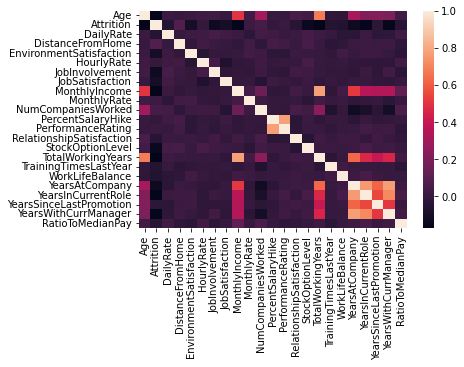

In [8]:
#Look for redundancies
_ = sns.heatmap(emp_data.corr(),xticklabels=True,yticklabels=True)

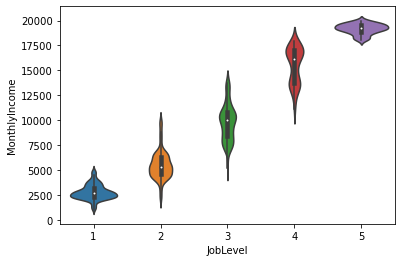

In [9]:
#Check strong associations. Using a violinplot to compare continuous variable MonthlyIncome vs. categorical variable JobLevel (I noticed the strong correlation from the heatmap before I realized JobLevel had not been re-converted to categorical yet)
_ = sns.violinplot(x='JobLevel',y='MonthlyIncome',data=emp_data)

In [10]:
#Create a function to jitter any column and return it as a new series
def jitter(df,column,span=1):
    jitter_frame = pd.DataFrame((np.random.random(size=(len(df[column]),1))-0.5)*span)
    return df[column].reset_index(drop=True)+jitter_frame.iloc[:,0]

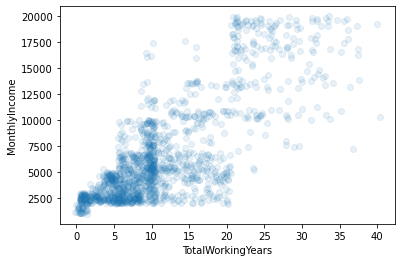

In [11]:
#Scatter plot to compare continuous variables TotalWorkingYears and MonthlyIncome
_ = plt.scatter(jitter(emp_data,'TotalWorkingYears'),emp_data['MonthlyIncome'],alpha=.1)
_ = plt.xlabel('TotalWorkingYears')
_ = plt.ylabel('MonthlyIncome')

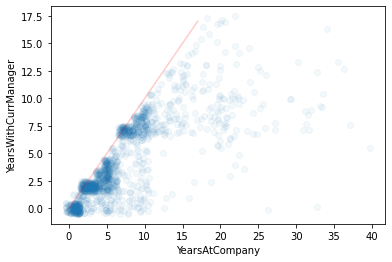

In [12]:
#Scatter plot to compare continuous variables YearsAtCompany and YearsWithCurrManager
_ = plt.scatter(jitter(emp_data,'YearsAtCompany'),jitter(emp_data,'YearsWithCurrManager'),alpha=.05)
_ = plt.xlabel('YearsAtCompany')
_ = plt.ylabel('YearsWithCurrManager')
#Add a line of equivalence
upper_bound = min(max(emp_data['YearsAtCompany']),max(emp_data['YearsWithCurrManager']))
_ = plt.plot([0,upper_bound],[0,upper_bound],color='red',alpha=0.2)

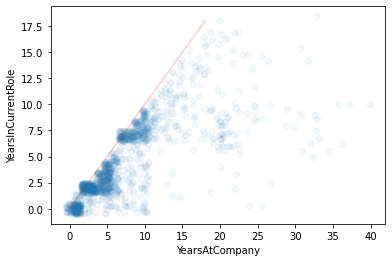

In [13]:
#Scatter plot to compare continuous variables YearsAtCompany and YearsInCurrentRole
_ = plt.scatter(jitter(emp_data,'YearsAtCompany'),jitter(emp_data,'YearsInCurrentRole'),alpha=.05)
_ = plt.xlabel('YearsAtCompany')
_ = plt.ylabel('YearsInCurrentRole')
#Add a line of equivalence
upper_bound2 = min(max(emp_data['YearsAtCompany']),max(emp_data['YearsInCurrentRole']))
_ = plt.plot([0,upper_bound2],[0,upper_bound2],color='red',alpha=0.2)

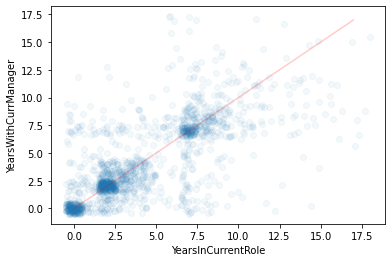

In [14]:
#Scatter plot to compare continuous variables YearsAtCompany and YearsInCurrentRole
_ = plt.scatter(jitter(emp_data,'YearsInCurrentRole'),jitter(emp_data,'YearsWithCurrManager'),alpha=.05)
_ = plt.xlabel('YearsInCurrentRole')
_ = plt.ylabel('YearsWithCurrManager')
#Add a line of equivalence
upper_bound3 = min(max(emp_data['YearsInCurrentRole']),max(emp_data['YearsWithCurrManager']))
_ = plt.plot([0,upper_bound3],[0,upper_bound3],color='red',alpha=0.2)

After examining the strongest correlations among numeric variables, it appears we may be able to ignore Job Level since will be less helpful as a discrete variable and is strongly correlated with monthly income.

TotalWorkingYears is pretty strongly correlated with monthly income but does not appear redundant enough to eliminate yet.

YearsAtCompany, YearsWithCurrManager, and YearsInCurrentRole do not appear redundant enough to eliminate yet.

HourlyRate, DailyRate, MonthlyRate, and MonthlyIncome don't appear to be correlated in the heatmap, though I would have expected them to be. Will create scatterplots to confirm the lack of relationship and validate the correlation heatmap.

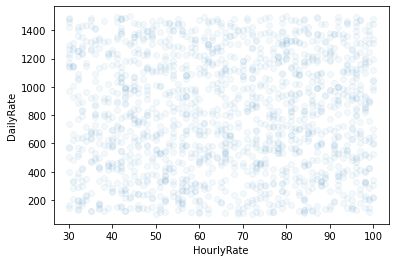

In [15]:
#Scatter plot to compare continuous variables HourlyRate and DailyRate
_ = plt.scatter(emp_data['HourlyRate'],emp_data['DailyRate'],alpha=.05)
_ = plt.xlabel('HourlyRate')
_ = plt.ylabel('DailyRate')

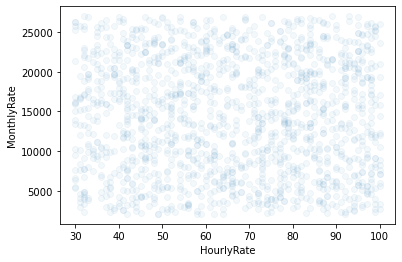

In [16]:
#Scatter plot to compare continuous variables HourlyRate and MonthlyRate
_ = plt.scatter(emp_data['HourlyRate'],emp_data['MonthlyRate'],alpha=.05)
_ = plt.xlabel('HourlyRate')
_ = plt.ylabel('MonthlyRate')

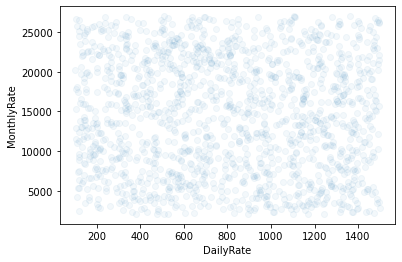

In [17]:
#Scatter plot to compare continuous variables DailyRate and MonthlyRate
_ = plt.scatter(emp_data['DailyRate'],emp_data['MonthlyRate'],alpha=.05)
_ = plt.xlabel('DailyRate')
_ = plt.ylabel('MonthlyRate')

It's unclear why none of the Rate fields are correlated either among themselves or with MonthlyIncome. Because of this and the fact that the data source does not explain the meaning of these columns, I will drop them.

In [18]:
emp_data.drop(columns=['DailyRate','HourlyRate','MonthlyRate'],inplace=True)
print(emp_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 1 to 2068
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Age                       1470 non-null   int64   
 1   Attrition                 1470 non-null   int64   
 2   BusinessTravel            1470 non-null   object  
 3   Department                1470 non-null   object  
 4   DistanceFromHome          1470 non-null   int64   
 5   Education                 1470 non-null   category
 6   EducationField            1470 non-null   object  
 7   EnvironmentSatisfaction   1470 non-null   int64   
 8   Gender                    1470 non-null   object  
 9   JobInvolvement            1470 non-null   int64   
 10  JobLevel                  1470 non-null   category
 11  JobRole                   1470 non-null   object  
 12  JobSatisfaction           1470 non-null   int64   
 13  MaritalStatus             1470 non-null   object

Create boxplots for the remaining continuous numerical fields by Attrition to see if the fields are distributed differently for those who showed Attrition and those who did not.

In [19]:
#Convert ordinal categorical variables to categorical, so they're not included in the boxplots
ordinals = ['EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','PerformanceRating','RelationshipSatisfaction','StockOptionLevel','TrainingTimesLastYear','WorkLifeBalance']
emp_data[ordinals]=emp_data[ordinals].astype('category')

In [20]:
#Compile all numerical fields other than Attrition
nums = emp_data.select_dtypes(exclude=['object','category']).drop(columns='Attrition').columns
print(nums)

Index(['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'TotalWorkingYears', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'RatioToMedianPay'],
      dtype='object')


In [21]:
#Create function to plot boxplots of each numerical feature by Attrition yes/no
def AttritionBox(column,axis):
    sns.boxplot(ax = axis, x='Attrition',y=column,data=emp_data)
    axis.set_xlabel('Attrition (1=Yes,0=No)')
    axis.set_ylabel('Distribution of '+column)
    axis.set_title('Distribution of '+column+' by Attrition')

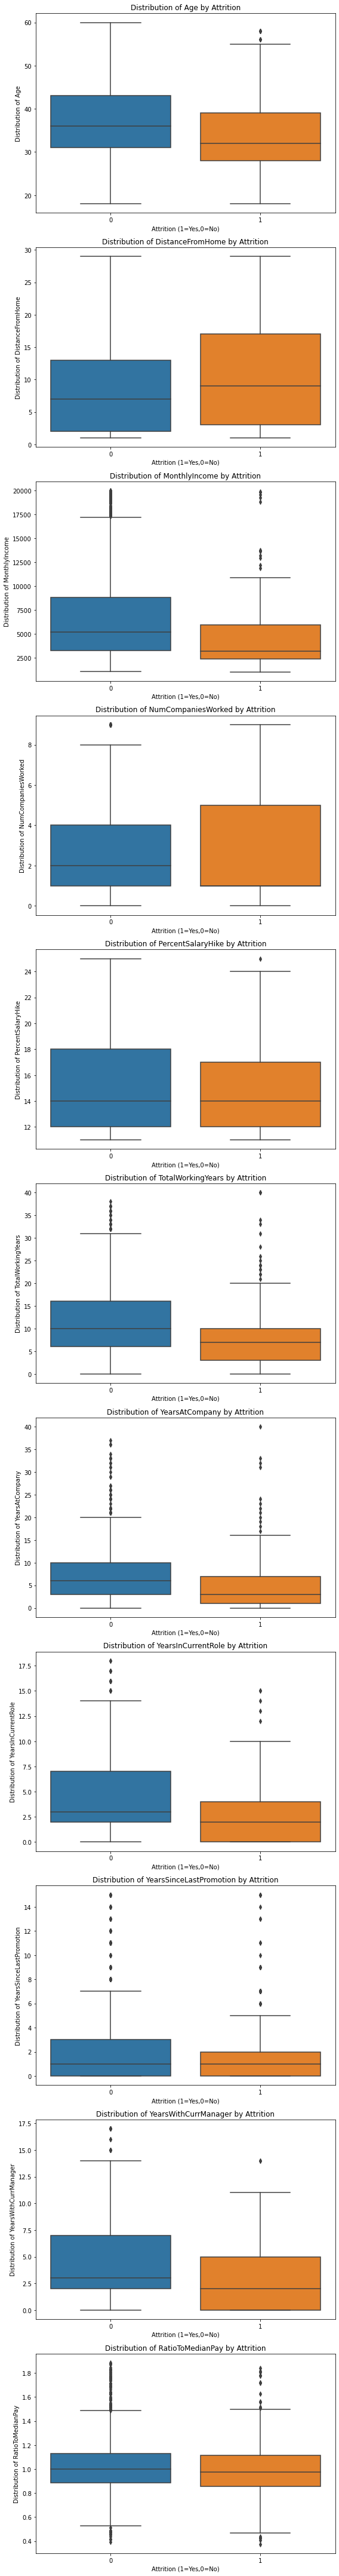

In [22]:
#Create subplots
fig, axes = plt.subplots(len(nums),1,figsize=(8,60))
for i in range(len(nums)):
    AttritionBox(nums[i],axes[i])
fig.tight_layout()

Create histograms for these continuous variables to see if log-scaling can help improve normality

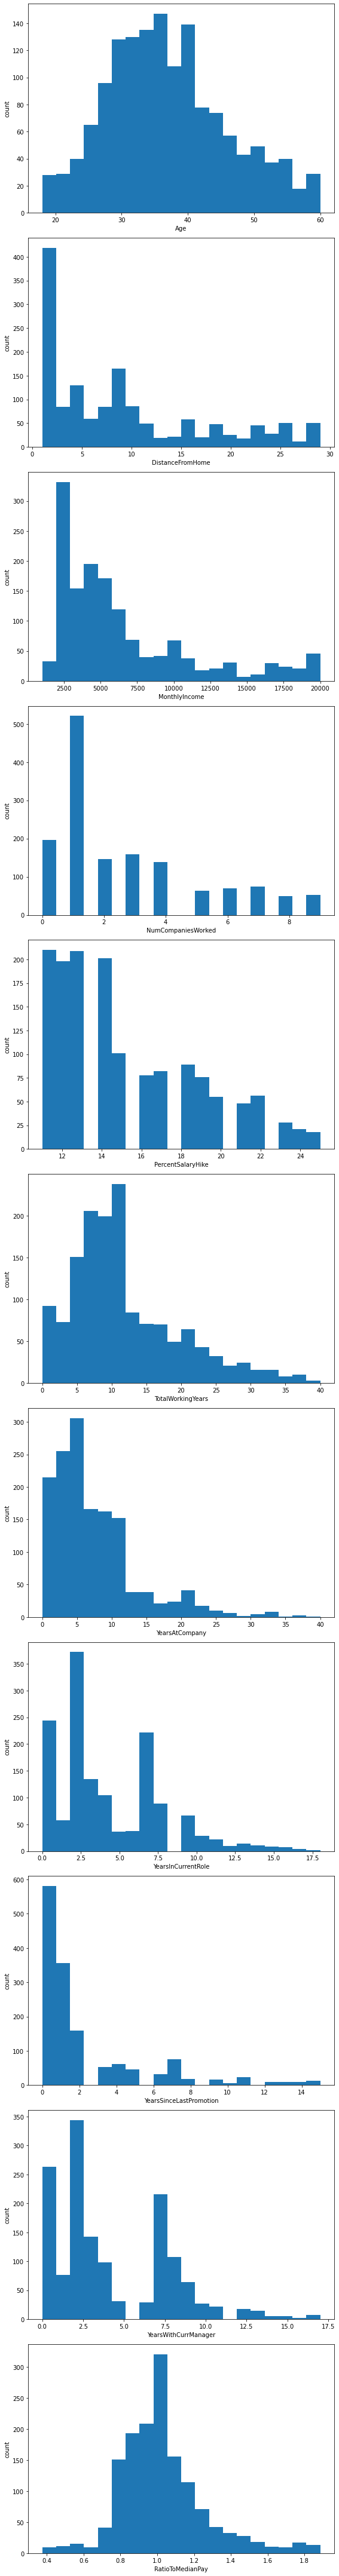

In [23]:
#Create subplots
fig, axes = plt.subplots(len(nums),1,figsize=(8,60))
for i in range(len(nums)):
    axes[i].hist(emp_data[nums[i]],bins=20)
    axes[i].set_xlabel(nums[i])
    axes[i].set_ylabel('count')
fig.tight_layout()

Part 3: Examine categorical features

In [24]:
#Compile all categorical fields
cats = emp_data.select_dtypes(include=['category','object']).columns
print(cats)

Index(['BusinessTravel', 'Department', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TrainingTimesLastYear', 'WorkLifeBalance'],
      dtype='object')


In [25]:
#Create function to plot bar charts of mean Attrition for each categorical feature
def AttritionBar(column,axis):
    bar_stats = emp_data.groupby(column)['Attrition'].agg(['mean','count'])
    sns.barplot(ax = axis, x=bar_stats.index,y=bar_stats['mean'])
    axis.bar_label(axis.containers[0],labels='n = '+bar_stats['count'].astype('str'))
    axis.set_xlabel(column)
    axis.set_ylabel('% Attrition')
    axis.set_title('% Attrition by '+column+' (sample size noted)')
    axis.set_yticks(np.arange(0,0.6,0.1))
    axis.set_xticklabels(labels=axis.get_xticklabels(),rotation=45)

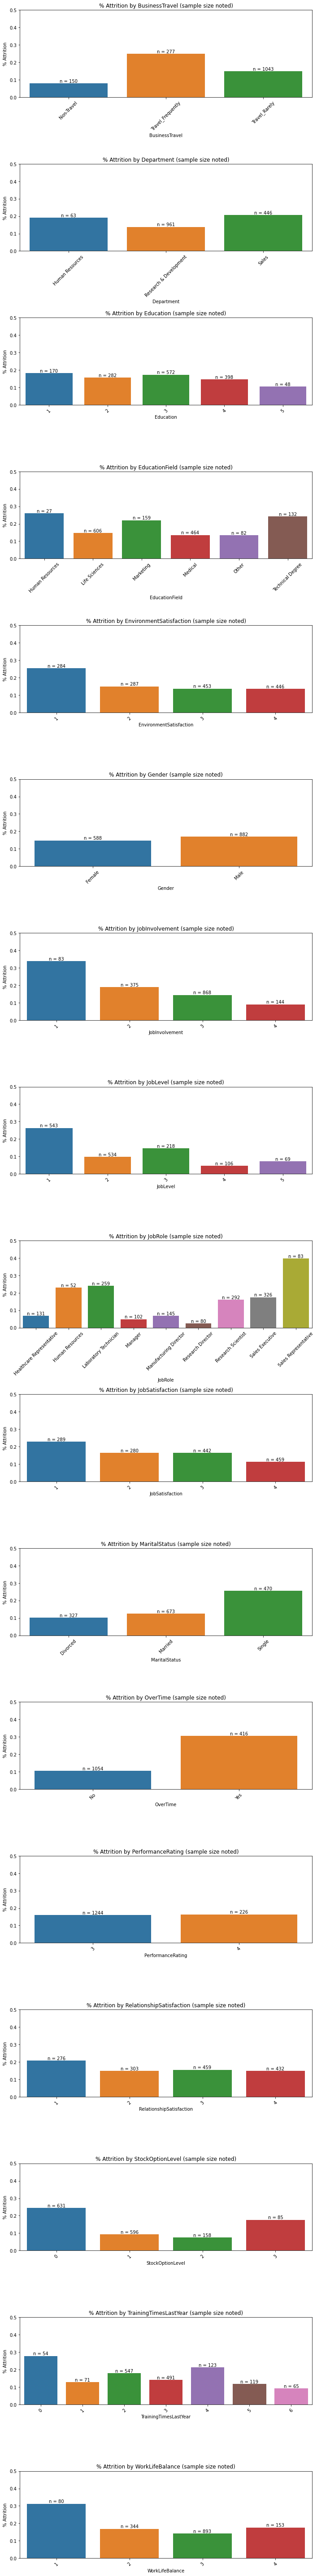

In [26]:
#Create subplots
fig, axes = plt.subplots(len(cats),1,figsize=(10,80))
for i in range(len(cats)):
    AttritionBar(cats[i],axes[i])
fig.tight_layout()

In [27]:
#save 2nd intermediate data file

emp_data.to_csv('../data/interim/emp_data_post_EDA.tsv',sep='\t')